# 모델은 왜 그렇게 예측하였을까? SHAP

## 1.환경준비

### 1) 라이브러리 설치 및 로딩

In [ ]:
!pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

tf.compat.v1.disable_v2_behavior()  # shap 그래프가 tf1 버전을 지원합니다. tf2는 비활성화.

import shap

Instructions for updating:
non-resource variables are not supported in the long term


### 2) 데이터 로딩

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 상업지역 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 

In [3]:
def plot_feature_importance(importance, names, topn='all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_temp.reset_index(drop=True, inplace=True)

    if topn == 'all':
        fi_df = fi_temp.copy()
    else:
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10, 8))
    sns.barplot(x='feature_importance', y='feature_names', data=fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비

### 1)데이터분할

In [4]:
target = 'medv'
x = data.drop(target, axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=10)

### 2)스케일링
* DL 모델과 SVM 모델에 사용

In [5]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

# x_train_s = pd.DataFrame(x_train_s, columns = list(x_train))
# x_val_s = pd.DataFrame(x_val_s, columns = list(x_val))

## 3.모델링 및 해석

* RandomForest


### 1) 학습

In [6]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

RandomForestRegressor()

### 2) 해석

#### ① Shapley Value 만들기

In [111]:
# SHAP 값으로 모델의 예측 설명하기
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(x_train)

In [112]:
x_train.shape, shap_values1.shape

((404, 13), (404, 13))

In [113]:
x_train[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
50,0.08873,21.0,5.64,0,0.439,5.963,45.7,6.8147,4,243,16.8,395.56,13.45
367,13.52220,0.0,18.10,0,0.631,3.863,100.0,1.5106,24,666,20.2,131.42,13.33


In [114]:
pd.DataFrame(shap_values1, columns=list(x))[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.298347,-0.004515,-0.088721,-0.005257,0.266262,-2.327334,0.207107,-0.465575,-0.017875,0.349645,0.253651,0.119393,-0.356964
1,0.301956,-0.004065,0.068966,0.001816,0.122023,-1.515346,-0.146480,0.186442,0.101219,-0.163586,-0.148860,-0.140573,0.103650


#### ② 특정 데이터에 대한 설명

In [115]:
x_train.iloc[0:1, :]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
50,0.08873,21.0,5.64,0,0.439,5.963,45.7,6.8147,4,243,16.8,395.56,13.45


* 예측값

In [116]:
# 예측하기 위해서는 입력데이터(x)가 2차원이어야 합니다.
pred = model1.predict(x_train.iloc[0:1, :])
pred

array([20.078])

* y_train의 평균 

In [117]:
y_train.mean()

21.84183168316832

* 예측값과 y평균간 차 ==> 예측값과 train의 예측값 전체 평균간 차

In [118]:
pred[0] - y_train.mean()

-1.763831683168302

In [119]:
y_train.mean(), y.mean()

(21.84183168316832, 22.532806324110677)

* Shapley Value

In [120]:
pd.DataFrame(shap_values1[0:1, :], columns=list(x_train))

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.298347,-0.004515,-0.088721,-0.005257,0.266262,-2.327334,0.207107,-0.465575,-0.017875,0.349645,0.253651,0.119393,-0.356964


* Shapley Value 합 : 소수점 반올림된 값 때문에 약간 차이가 있음(넘어갑시다.^^)

In [121]:
shap_values1[0:1, :].sum()

-1.7718366336633482

* 그래프로 그려 봅시다.

In [122]:
# y_train의 평균
explainer1.expected_value

array([21.84983663])

In [123]:
shap.initjs()  # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[0, :], x_train.iloc[0, :])

* 집값 형성에 대해서, 예측결과가 결정 되는데, 
    * 상승 요인 : 
    * 하락 요인 : 

## 4.실습

* 모델의 전체 중요도로 볼 때, lstat가 집값에 가장 큰 영향을 줍니다.
* lstat와 집값(medv)의 관계를 살펴보면, 강한 음의 상관관계가 있음을 알수 있습니다. 
* 그러나, 이 관계에서 벗어난 데이터들이 존재합니다. 이들에 대해서 집값을 예측하는데 영향을 주는 요인을 각각 찾아 설명해 봅시다.

### 1) 모델의 변수 중요도 

In [ ]:
model2 =

### 2) 전체 흐름에서 벗어나 보이는 값들 분석하기

* 아래 그래프를 보면 index 371, 266, 505, 214 데이터가 전체 흐름과 다른 집값을 나태내고 있습니다. 
* 이 값들에 대해서 shapley value를 확인하고 그래프를 통해 이유를 설명해 봅시다.

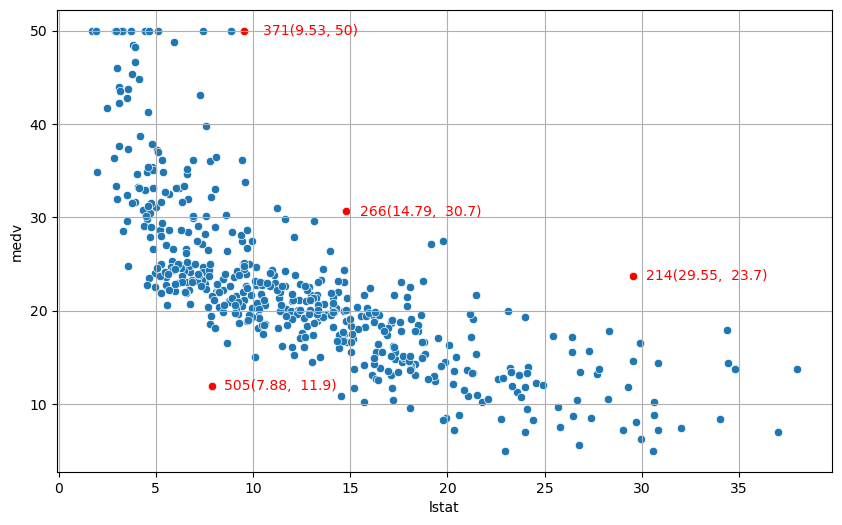

In [48]:
plt.figure(figsize=(10, 6))
plt.style.use('default')
sns.scatterplot(x='lstat', y='medv', data=data)

sns.scatterplot(x='lstat', y='medv', data=data.iloc[[371]], color='r')
plt.text(10.5, 49.6, '371(9.53, 50)', color='r')
sns.scatterplot(x='lstat', y='medv', data=data.iloc[[266]], color='r')
plt.text(15.5, 30.2, '266(14.79,  30.7)', color='r')
sns.scatterplot(x='lstat', y='medv', data=data.iloc[[505]], color='r')
plt.text(8.5, 11.5, '505(7.88,  11.9)', color='r')
sns.scatterplot(x='lstat', y='medv', data=data.iloc[[214]], color='r')
plt.text(30.2, 23.3, '214(29.55,  23.7)', color='r')

plt.grid()
plt.show()

In [124]:
# SHAP 값으로 모델의 예측 설명하기
shap_values1 = explainer1.shap_values(x)

* index = 371

In [90]:
index = 371

In [91]:
x.iloc[[index], :]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
371,9.2323,0.0,18.1,0,0.631,6.216,100.0,1.1691,24,666,20.2,366.15,9.53


In [92]:
pd.DataFrame(shap_values1[[index], :], columns=x.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,1.310367,-0.002578,-0.001859,-0.00893,-0.008324,-0.420838,-0.142629,11.533222,0.059656,-0.212025,-0.206594,0.171153,6.595543


In [93]:
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index, :])

* index = 266

In [126]:
index=266

In [127]:
x.iloc[[index],:]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
266,0.7857,20.0,3.97,0,0.647,7.014,84.6,2.1329,5,264,13.0,384.07,14.79


In [128]:
pd.DataFrame(shap_values1[[index],:], columns=x.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.20878,0.032595,0.053633,-0.002586,-0.018154,7.795273,0.069906,0.117158,0.050661,0.352043,0.578009,0.216206,-1.609361


In [129]:
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index,:])

In [98]:
x.iloc[371, :].sum()

1221.2284

* index = 505

In [107]:
index = 505

In [108]:
x.iloc[[index], :]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
505,0.04741,0.0,11.93,0,0.573,6.03,80.8,2.505,1,273,21.0,396.9,7.88


In [109]:
pd.DataFrame(shap_values1[[index], :], columns=x.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,-0.028309,-0.069915,-0.01436,-0.00819,0.112057,-3.924919,-0.622628,-0.122907,-0.710975,0.105637,-1.081729,0.006864,-0.628462


In [110]:
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index, :])

* index = 214

In [103]:
index = 214

In [104]:
x.iloc[[index], :]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
214,0.28955,0.0,10.59,0,0.489,5.412,9.8,3.5875,4,277,18.6,348.93,29.55


In [105]:
pd.DataFrame(shap_values1[[index], :], columns=x.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.913608,-0.005245,0.034149,-0.015389,0.893022,-2.047789,0.709332,0.35397,-0.007485,0.429895,0.245647,-0.143955,-5.352598


In [106]:
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index, :])

## 5.추가 분석

### 1) 데이터 전체를 한눈에

#### ① 전체 변수에 대한 shap value 시각화
* 각 변수별 shapley value 분포를 한눈에 보여줍니다.
* 색깔은 해당 변수의 값의 크기를 나타냅니다.

In [130]:
shap_values1 = explainer1.shap_values(x_train)

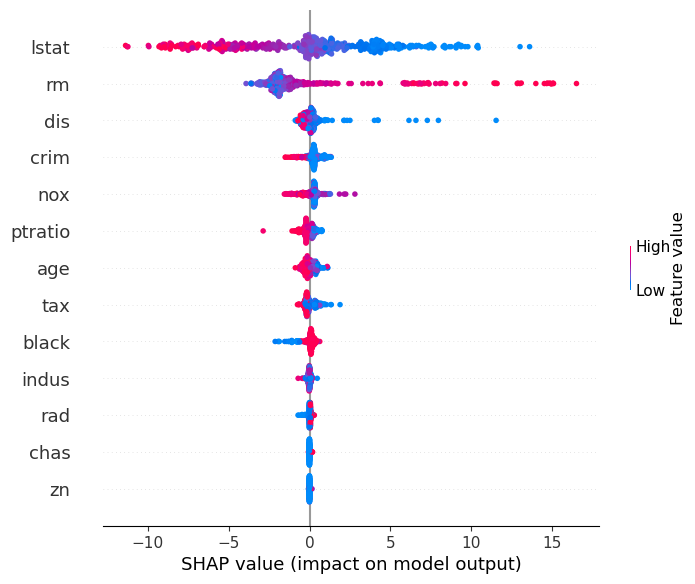

In [131]:
shap.summary_plot(shap_values1, x_train)

#### ② 특정 관점으로 Data point이 Shap Value 정렬

In [132]:
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, x_train)

#### ③ 특정 변수 값과 변수의 shap value 간의 관계

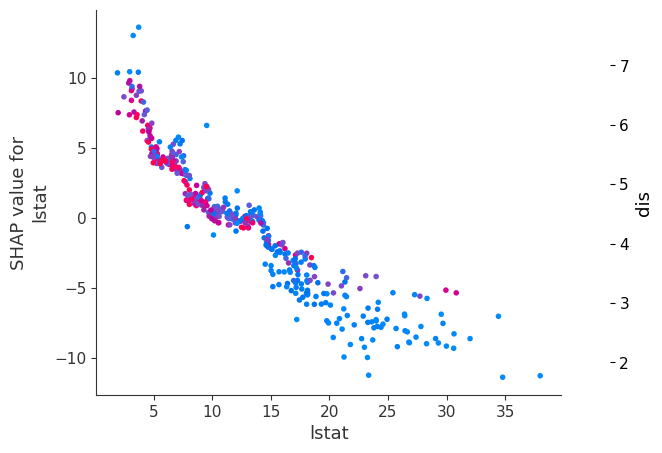

In [138]:
shap.dependence_plot('lstat', shap_values1, x_train)

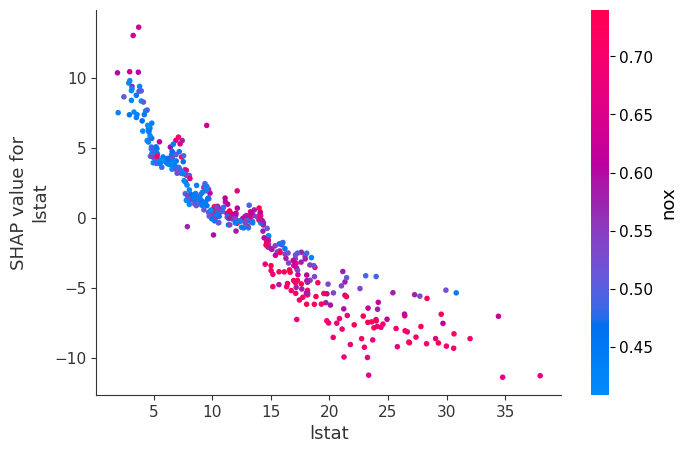

In [134]:
shap.dependence_plot('lstat', shap_values1, x_train, interaction_index='nox')

-----------
아래 내용은 시간이 많이 걸리기에 **참조 자료** 로 보시면 좋겠습니다.^^

### 2) KernelExplainer

* SVM에 대한 shapley value 계산은 엄청 오래 걸립니다.
* 그래서 데이터를 줄여서 수행합니다.

#### ① SVM 모델링

In [139]:
model2 = SVR()
model2.fit(x_train_s, y_train)

SVR()

#### ② Shap Value 만들기
* shap.KernelExplainer(모델.**predict**, x)
    * TreeExplainer는 그냥 모델을 넣었지만, KernelExpaliner는 모델.**predict**로 넣어야 합니다.
* 데이터를 줄여서 10건만 수행합니다.

In [151]:
explainer2 = shap.KernelExplainer(model2.predict, x_train_s)

# 10건만 줄여서 수행합니다. 
shap_values2 = explainer2.shap_values(x_train_s)

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/404 [00:00<?, ?it/s]

In [152]:
shap_values2

array([[ 0.08614652,  0.2064142 ,  0.3496551 , ...,  0.84440527,
         0.24030733, -0.14312445],
       [-0.28313441, -0.20342909, -0.35553537, ..., -0.56774192,
        -1.37505254, -0.06400918],
       [ 0.06231138, -0.29408498,  0.06315234, ..., -1.2703566 ,
        -0.72195265, -2.06439757],
       ...,
       [ 0.08036102, -0.174185  , -0.32794327, ..., -0.56639329,
         0.15573692, -0.02012889],
       [ 0.09703061, -0.22381653, -0.64051408, ..., -0.34299875,
         0.16941617, -0.46433483],
       [ 0.09143524,  0.24229783,  0.62042961, ...,  2.67677774,
         0.27493122,  0.73352361]])

In [154]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2, x_train_s)

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0], x_train.iloc[0])

### 3) DeepExplainer

#### ① DL 모델링

In [144]:
# 간단한 DL 모델을 생성합니다.
nfeatures = x_train.shape[1]

clear_session()

model3 = Sequential([Dense(4, input_shape=(nfeatures,), activation='relu'),
                     Dense(1)])

model3.compile(optimizer=Adam(lr=0.1), loss='mse')

history = model3.fit(x_train_s, y_train,
                     epochs=100, batch_size=64,
                     validation_split=0.2).history

Train on 323 samples, validate on 81 samples
Epoch 1/100
 64/323 [====>.........................] - ETA: 0s - loss: 415.7182WARNING:tensorflow:From C:\Users\allsa\anaconda3\envs\kt-aivle\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
323/323 [==============================] - 0s 142us/sample - loss: 498.4855 - val_loss: 403.5324
Epoch 2/100
323/323 [==============================] - 0s 15us/sample - loss: 299.9397 - val_loss: 173.4186
Epoch 3/100
323/323 [==============================] - 0s 15us/sample - loss: 142.5936 - val_loss: 104.4593
Epoch 4/100
323/323 [==============================] - 0s 19us/sample - loss: 122.8341 - val_loss: 89.7861
Epoch 5/100
323/323 [==============================] - 0s 15us/sample - loss: 101.91

#### ② Shap Value 만들기

* DeepExplainer로 부터 shap_values를 추출하면
    * **리스트 안에 np.array로 값이 저장**됩니다.(아니..왜...)
    * 그래서 이를 사용하려면 값을 뽑아내서(리스트[0])로 사용해야 합니다.

In [145]:
explainer = shap.DeepExplainer(model3, x_train_s)
shap_values = explainer.shap_values(x_train_s)

keras is no longer supported, please use tf.keras instead.


In [146]:
shap_values

[array([[ 0.4470565 ,  0.34453518,  0.17612427, ...,  1.29323395,
          0.60391485, -0.22248829],
        [-1.13025124, -0.3979206 , -0.19595591, ..., -1.21993431,
         -3.18864706, -0.17331735],
        [ 0.26737407, -0.3979206 ,  0.10133937, ..., -1.81090127,
         -1.51217227, -4.01096655],
        ...,
        [ 0.17811995, -0.3979206 , -0.19585321, ..., -1.21982531,
          0.24695629, -0.1634402 ],
        [ 0.43762396, -0.3979206 , -0.42123708, ..., -0.40677632,
          0.45240082, -0.96968244],
        [ 0.3684161 ,  0.30929239,  0.22605487, ...,  4.10279313,
          0.55857305,  1.42776032]])]

In [147]:
# 리스트에서 값을 빼내기
shap_values = shap_values[0]

In [148]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train)

In [149]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_train.iloc[0])

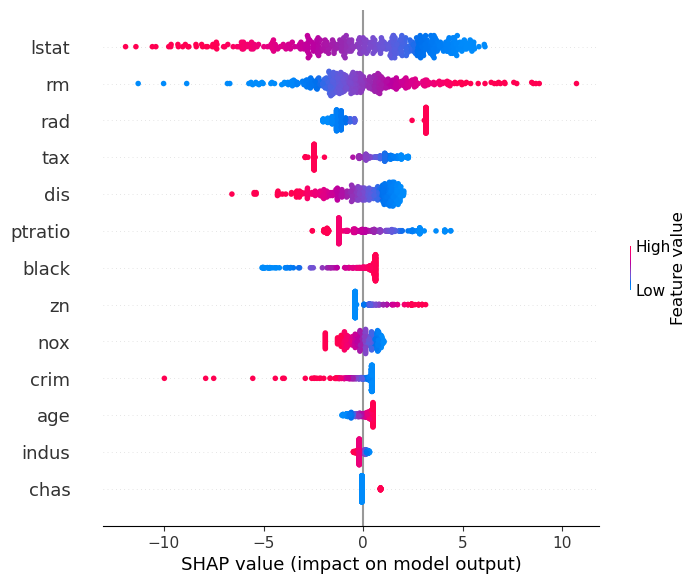

In [150]:
shap.summary_plot(shap_values, x_train)